# Single Cell apoptosis

#### As decribed in Monier et al. 2015

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
%matplotlib inline
from scipy import optimize

from tyssue.core.sheet import Sheet
from tyssue.config.json_parser import load_default

from tyssue.geometry.sheet_geometry import SheetGeometry as geom
from tyssue.dynamics.apoptosis_model import SheetApoptosisModel as model
from tyssue.dynamics.sheet_vertex_model import SheetModel as basemodel
from tyssue.solvers.sheet_vertex_solver import Solver as solver

#from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.vispy_draw import vp_view
from tyssue.topology.sheet_topology import type1_transition, remove_face

from tyssue.draw.mpl_draw import sheet_view
import tyssue.draw.mpl_draw as draw
from tyssue.stores import load_datasets

### Loading a dataset

Here it is a cylindrical hexagonal mesh.

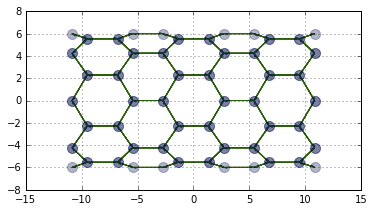

In [2]:
h5store = 'small_hexagonal.hf5'
datasets = load_datasets(h5store,
                         data_names=['face', 'vert', 'edge'])

sheet = Sheet('emin', datasets)
sheet.set_geom('sheet')
geom.update_all(sheet)

nondim_specs = load_default('dynamics', 'sheet')
dim_model_specs = model.dimentionalize(nondim_specs)

sheet.set_model('sheet', dim_model_specs)

fig, ax = sheet_view(sheet, ['z', 'x'], **{'edge': {'width':1.}})

In [3]:
live_edges = sheet.upcast_face(sheet.face_df.is_alive)
dead_src = set(sheet.edge_df[live_edges==0].srce)

sheet.vert_df.is_active = 1
sheet.vert_df.loc[dead_src, 'is_active'] = 0

In [4]:
settings = {
    'minimize': {
        'options': {
            'disp': False,
            'ftol': 1e-6,    
            'gtol': 1e-5},
        }
    }

res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])

True


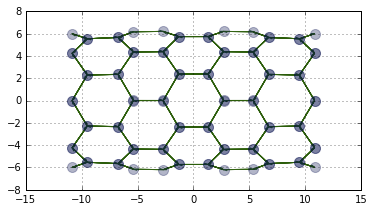

In [5]:
fig, ax = sheet_view(sheet, ['z', 'x'], **{'edge': {'width':1.}})

In [6]:
apoptotic_cell = 45

apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] == apoptotic_cell]
apoptotic_verts = apoptotic_edges['srce'].values
print("Indices of the apoptotic vertices: {}".format(apoptotic_verts))

Indices of the apoptotic vertices: [75 78 76 81 90 87]


In [7]:


n_steps = 20

pref_vols = np.logspace(0, -9, n_steps, base=2) * sheet.specs['face']['prefered_vol']
rad_tensions = np.linspace(0, 1, n_steps) * sheet.specs['edge']['line_tension']

for i, (pref_v, rad_tens) in enumerate(zip(pref_vols, rad_tensions)):
    sheet.face_df.loc[apoptotic_cell, 'prefered_vol'] = pref_v
    sheet.vert_df.loc[apoptotic_verts, 'radial_tension'] = rad_tens
    res = solver.find_energy_min(sheet, geom, model, **settings)
    #fig, ax = sheet_view(sheet, ['z', 'x'])
    #plt.savefig('test_apopto_{:03d}.png'.format(i))
    #plt.close()
    


In [8]:
vp_view(sheet)

/home/guillaume/anaconda3/envs/py35/lib/python3.5/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)


In [9]:
j = 0
while len(apoptotic_edges) > 3:
    j += 1
    shorter = apoptotic_edges.length.argmin()
    type1_transition(sheet, shorter)
    geom.update_all(sheet)
    res = solver.find_energy_min(sheet, geom, 
                                 model, **settings)
    apoptotic_edges = sheet.edge_df[sheet.edge_df['face'] ==
                                    apoptotic_cell]
    print(len(apoptotic_edges))
    
    #fig, ax = sheet_view(sheet, ['z', 'x'])
    #plt.savefig('test_apopto_{:03d}.png'.format(i+j))
    #plt.close()

5
4
3


In [10]:
remove_face(sheet, apoptotic_cell)
geom.update_all(sheet)
res = solver.find_energy_min(sheet, geom, model, **settings)

In [11]:
vp_view(sheet)

In [ ]:


res = solver.find_energy_min(sheet, geom, model, **settings)
print(res['success'])
fig, ax = sheet_view(sheet, ['z', 'x'])